**novelty detection**:
The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

**outlier detection**:
The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [75]:
!source activate py2

/bin/sh: activate: No such file or directory


In [76]:
#!/anaconda3/envs/py2/bin/pip install cvxopt

In [77]:
import numpy as np
from cvxopt import solvers, lapack, matrix, spmatrix
solvers.options['show_progress'] = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

In [78]:
def RBF_Kernel(X, sigma2, Y = None):
    " Compute the RBF kernel matrix of X"
    from sklearn.metrics.pairwise import euclidean_distances
    
    if type(Y)==type(None):
        Y = X
    
    K = euclidean_distances(X,Y, squared=True)
    K *= -1./sigma2
    K = np.exp(K)
    return K

In [79]:
def Poly_Kernel(X, d, c, Y=None):
    if type(Y)==type(None):
        Y = X.copy()
    K = ( np.dot(X,Y.T) +c)**d
    #from sklearn.metrics.pairwise import polynomial_kernel
    #K = polynomial_kernel(X,Y,degree=d,coef0=c)
    return(K)

In [80]:
def fit(X, nu, kernel):  #kernel is a list [kernel_type,sigma/d,c]
    n = X.shape[0]
    if kernel[0] == 'RBF':
        sigma2 = kernel[1]
        K = RBF_Kernel(X, sigma2)
    else:
        d, c = kernel[1:]
        K = Poly_Kernel(X,d,c)

    P = matrix(K, tc = 'd')
    q = matrix([0]*n, tc = 'd')
    G = matrix(np.concatenate([np.eye(n),-np.eye(n)], axis = 0), tc = 'd')
    h_value = [1./(n * nu)]*n
    h_value.extend([0]*n)
    h = matrix(h_value, tc = 'd')
    A = matrix(np.reshape([1]*n, (1,n)), tc = 'd')
    b = matrix(1, tc = 'd')
    
    sol = solvers.qp(P,q,G,h,A,b)
    alpha = np.array(sol['x'])
    ix_in = np.where((alpha > 1e-5) & (alpha < 1./(n*nu)))[0][0]
    rho = np.transpose(np.dot(np.reshape(alpha, (1,n)), K[:,ix_in]))

    return alpha, rho

def predict(X, newData, alpha, rho, kernel):
    n = X.shape[0]
    if kernel[0] == 'RBF':
        sigma2 = kernel[1]
        K = RBF_Kernel(X, sigma2, newData)
    else:
        d, c = kernel[1:]
        K = Poly_Kernel(X,d,c,Y=newData)
    return np.transpose(np.dot(np.reshape(alpha, (1,n)), K) - rho)

In [81]:
def get_grid(X, step = 0.05):
    x_axis = np.arange(min(X[:,0])-step,max(X[:,0])+2*step,step)
    y_axis = np.arange(min(X[:,1])-step,max(X[:,1])+2*step,step)

    my_grid = []
    for i in x_axis:
        for j in y_axis:
            my_grid.append([i,j])#,1])
    my_grid = np.array(my_grid)
    
    return x_axis, y_axis, my_grid

def plot(X,step):
    plt.scatter(X[:,0], X[:,1], edgecolors  = 'black')
    plt.xlim((min(X[:,0])-step,max(X[:,0])+step))
    plt.ylim((min(X[:,1])-step,max(X[:,1])+step))
    pass

def Normalize_Pred(pred):    
    pred_100 = pred -np.min(pred)
    pred_100 = (pred_100 / np.max(pred_100)) * 100
    return pred_100

def get_delim(pred_100, x_axis, y_axis, eps = 0):
    ix_delim = np.where((pred_100  < eps) & (pred_100  > -eps))[0]
    x_delim = []
    y_delim = []
    for i in range(len(ix_delim)):
        a, b = np.divmod(ix_delim[i],len(y_axis))
        x_delim.append(x_axis[a])
        y_delim.append(y_axis[b])
    return x_delim, y_delim

def plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = 0.05):
    norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
    X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
    C = np.transpose(pred_100.reshape((len(x_axis), len(y_axis))))
    plt.pcolor(X_axis, Y_axis, C, norm= norm_colors, cmap = 'YlOrRd')
    plt.scatter(x_delim, y_delim, c = 'blue', s = 10)
    plot(X,step)
    plt.xlim((min(X[:,0])-step,max(X[:,0])+step))
    plt.ylim((min(X[:,1])-step,max(X[:,1])+step))
    pass

def plot_pred_plan(X, alpha, rho, kernel, step = 0.05, eps = 0):
    x_axis, y_axis, my_grid = get_grid(X, step)
    pred = predict(X, my_grid, alpha, rho, kernel)
    x_delim, y_delim = get_delim(pred, x_axis, y_axis, eps)
    pred_100 = Normalize_Pred(pred)
    #print("pred100",pred_100.shape)
    plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step)
    return pred

## Artifical data

In [82]:
X = np.random.normal(0,0.1,size=[200,2])
X_2class = np.random.normal(1,0.05,size=[20,2])

X2 = np.concatenate((X,X_2class),axis=0)

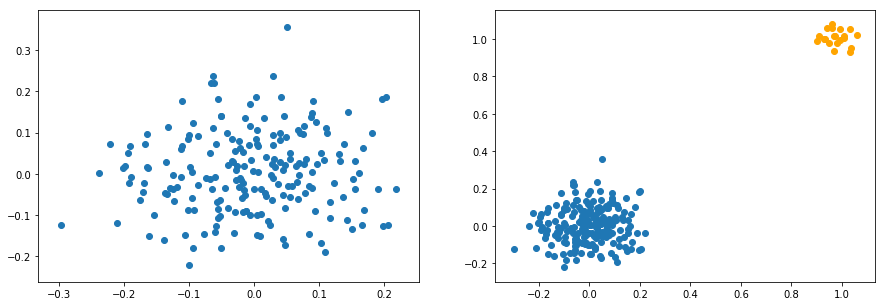

In [83]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(X[:,0],X[:,1])
plt.subplot(122)
plt.scatter(X[:,0],X[:,1])
plt.scatter(X_2class[:,0],X_2class[:,1],c='orange')
plt.show()

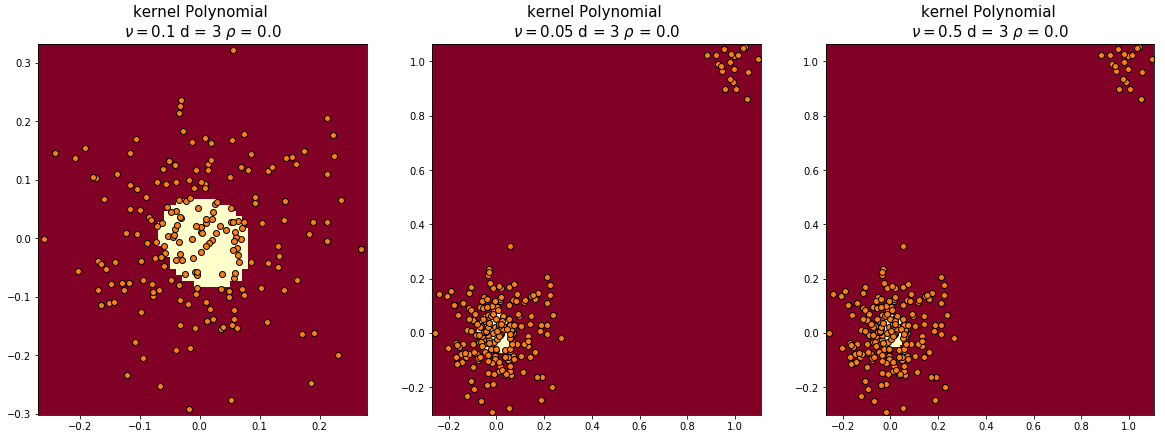

In [16]:
step = 0.01
nu = [0.1,0.05]


plt.figure(figsize=(20,15))


####### RBF ########

"""sigma2=0.5

plt.subplot(2,3,1)
nu=0.1
kernel = ['RBF',sigma2]
alpha, rho = fit(X, nu, kernel)
plt.title('kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred = plot_pred_plan(X, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)
                       

plt.subplot(2,3,2)
kernel = ['RBF',sigma2]
nu=0.1
alpha, rho = fit(X2, nu, kernel)
plt.title('Kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

plt.subplot(2,3,3)
nu=0.3
kernel = ['RBF',sigma2]
alpha, rho = fit(X2, nu, kernel)
plt.title('Kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)
"""

#### POLYNOMIAL  #######
d=3
c=0.1

plt.subplot(2,3,4)
nu=0.1
kernel = ['Poly',d,c]
alpha, rho = fit(X, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred = plot_pred_plan(X, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)                    

plt.subplot(2,3,5)
nu=0.05
kernel = ['Poly',d,c]
alpha, rho = fit(X2, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

plt.subplot(2,3,6)
nu=0.5
kernel = ['Poly',d,c]
alpha, rho = fit(X2, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

#plt.show()
plt.savefig('fake_data_plot')

### testing K means

In [84]:
class OCC:
    
    def __init__(self, X, step = 0.05, eps = 0):
        import matplotlib.pyplot as plt
        import numpy as np
        
        self.X = X
        self.n = X.shape[0]
        self.figsize = (10,5)
        
        # plot parameters
        self.step = step
        self.eps = eps
        self.norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
        self.set_grid()
        
        pass
    
    # Plot functions
    
    def plot(self):
        plt.scatter(self.X[:,0], self.X[:,1], edgecolors  = 'black')
        plt.xlim((min(self.X[:,0])-self.step,max(self.X[:,0])+self.step))
        plt.ylim((min(self.X[:,1])-self.step,max(self.X[:,1])+self.step))
        pass
    
    def set_grid(self):
        self.x_axis = np.arange(min(self.X[:,0])-self.step,max(self.X[:,0])+2*self.step,self.step)
        self.y_axis = np.arange(min(self.X[:,1])-self.step,max(self.X[:,1])+2*self.step,self.step)

        self.my_grid = []
        for i in self.x_axis:
            for j in self.y_axis:
                self.my_grid.append([i,j])
        self.my_grid = np.array(self.my_grid)

        pass

    def Normalize_Pred(self):    
        self.pred_100 = self.pred -np.min(self.pred)
        self.pred_100 = (self.pred_100 / np.max(self.pred_100)) * 100
        pass

    def set_delim(self):
        ix_delim = np.where((self.pred  < self.eps) & (self.pred  > -self.eps))[0]
        self.x_delim = []
        self.y_delim = []
        for i in range(len(ix_delim)):
            a, b = np.divmod(ix_delim[i],len(self.y_axis))
            self.x_delim.append(self.x_axis[a])
            self.y_delim.append(self.y_axis[b])
        pass

    def plot_pred(self, pred):
        
        X_axis, Y_axis = np.meshgrid(self.x_axis, self.y_axis)
        C = np.transpose(pred.reshape((len(self.x_axis), len(self.y_axis))))
        plt.pcolor(X_axis, Y_axis, C, norm = self.norm_colors, cmap = 'YlOrRd')
        plt.scatter(self.x_delim, self.y_delim, c = 'black', s = 10)
        self.plot()
        pass

    def plot_pred_plan(self):
        self.pred = self.predict(self.my_grid)
        self.pred_bin = np.sign(self.pred)
        self.set_delim()
        self.Normalize_Pred()
        
        plt.figure(figsize=self.figsize)
        plt.subplot(1,2,1)
        self.plot_pred(self.pred_100)
        plt.subplot(1,2,2)
        self.plot_pred((self.pred_bin+1)*100)
        pass
    
    
    # Skeletons for fit and predict
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    # Others methods
    def RBF_Kernel(self, X, sigma2, Y = None):
        " Compute the RBF kernel matrix of X"
        from sklearn.metrics.pairwise import euclidean_distances

        if type(Y)==type(None):
            Y = X

        K = euclidean_distances(X,Y, squared=True)
        K *= -1./sigma2
        K = np.exp(K)
        return K

In [85]:
class OkMeans(OCC):
    " Visual Object Recognition through One-Class Learning \
      QingHua Wang, Luís Seabra Lopes, and David M. J. Tax "
    
    def fit(self, thresh, k, kernel = False):
        from sklearn.cluster import KMeans
        
        self.thresh = thresh
        self.k = k
        self.kernel = kernel
        if kernel:
            K = self.RBF_Kernel(self.X, 1)            
        else:
            K = self.X

        kmeans = KMeans(n_clusters=k).fit(K)
        self.centers = kmeans.cluster_centers_
        
        pass
    
    def predict(self, newData):
        from sklearn.metrics.pairwise import euclidean_distances
        if self.kernel:
            newData = np.transpose(self.RBF_Kernel(self.X, 1, newData))
        D = euclidean_distances(newData, self.centers, squared=True)
        D = np.min(D, axis = 1)
        pred = -D + self.thresh
        return pred

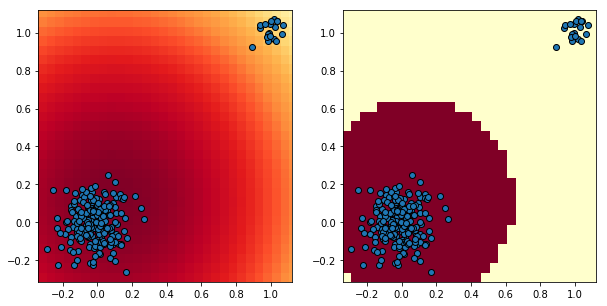

In [119]:
kmeans = OkMeans(X2)

kmeans.fit(0.3,k=1)

pred = kmeans.predict(X2)

kmeans.plot_pred_plan()

## Application to real data

### Thyroid data

http://odds.cs.stonybrook.edu/thyroid-disease-dataset/

In [93]:
from scipy.io import loadmat
x = loadmat('thyroid.mat')
X=x['X']
y=x['y'].flatten()
y[y==1]=-1
y[y==0]=1

#normalize the data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

print("share of outliers on test set:",len(y_test[y_test==-1])/len(y_test))

share of outliers on test set: 0.022968197879858657


### OSVM

In [87]:
def cross_val_OSVM(list_sigma2,list_nu,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    list_param = []
    for sigma in list_sigma2:
        for nu in list_nu:
            list_param.append((sigma,nu))
    false_pos = []
    for sigma2_val,nu_val in list_param:
        kernel = ['RBF',sigma2_val]
        alpha, rho = fit(X_train, nu_val, kernel)
        y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()
        conf = confusion_matrix(y_test,y_pred)
        #minimize false negatives ?
        print("sigma2: ",sigma2_val,"nu: ",nu_val,"false pos",np.round(conf[1][0]/np.sum(conf[0][0]+conf[1][0]),2) )
        false_pos.append( np.round(conf[0][1]/np.sum(conf[0][1]+conf[0][0]),2) )
    i_best = np.argmin(false_pos)
    best_param = list_param[i_best]
    sigma2_best, nu_best = [ best_param[0], best_param[1] ]
    return( sigma2_best, nu_best )

#### RBF $\nu$ = 0.2

In [104]:
nu_best = 0.1
sigma2_best = 10
kernel = ['RBF',sigma2_best]
#kernel = ['Poly',3,1]
alpha, rho = fit(X_train, nu_best, kernel)
y_pred_base = predict(X_train, X_test, alpha, rho, kernel).flatten()
y_pred = np.sign(y_pred_base)
y_pred_train_base = predict(X_train, X_train, alpha, rho, kernel).flatten()

In [105]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y_test,y_pred)
print(conf)
print(classification_report(y_test,y_pred))
print("false positive rate:",np.round(conf[0][1]/(conf[0][1]+conf[0][0]),3))
print("true pos rate:",np.round(conf[1][1]/(conf[1][0]+conf[1][1]),3))

[[  19    7]
 [  89 1017]]
             precision    recall  f1-score   support

       -1.0       0.18      0.73      0.28        26
        1.0       0.99      0.92      0.95      1106

avg / total       0.97      0.92      0.94      1132

false positive rate: 0.269
true pos rate: 0.92


#### RBF $\nu$ = 0.5

In [102]:
nu_best = 0.5
sigma2_best = 10
kernel = ['RBF',sigma2_best]
alpha_2, rho_2 = fit(X_train, nu_best, kernel)
y_pred_base_2 = predict(X_train, X_test, alpha_2, rho_2, kernel).flatten()
y_pred_2 = np.sign(y_pred_base_2)
y_pred_train_base2 = predict(X_train, X_train, alpha_2, rho_2, kernel).flatten()

In [103]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y_test,y_pred_2)
print(conf)
print(classification_report(y_test,y_pred_2))
print("false positive rate:",np.round(conf[0][1]/(conf[0][1]+conf[0][0]),3))
print("true pos rate:",np.round(conf[1][1]/(conf[1][0]+conf[1][1]),3))

[[ 26   0]
 [251 855]]
             precision    recall  f1-score   support

       -1.0       0.09      1.00      0.17        26
        1.0       1.00      0.77      0.87      1106

avg / total       0.98      0.78      0.86      1132

false positive rate: 0.0
true pos rate: 0.773


#### Poly $\nu$ = 0.5

In [62]:
nu_best = 0.5
sigma2_best = 10
kernel = ['Poly',2,1]
alpha_2, rho_2 = fit(X_train, nu_best, kernel)
y_pred_base_2 = predict(X_train, X_test, alpha_2, rho_2, kernel).flatten()
y_pred_2 = np.sign(y_pred_base_2)
y_pred_train_base2 = predict(X_train, X_train, alpha_2, rho_2, kernel).flatten()

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y_test,y_pred_2)
print(conf)
print(classification_report(y_test,y_pred_2))
print("false positive rate:",np.round(conf[0][1]/(conf[0][1]+conf[0][0]),3))
print("true pos rate:",np.round(conf[1][1]/(conf[1][0]+conf[1][1]),3))

[[ 26   0]
 [251 855]]
             precision    recall  f1-score   support

       -1.0       0.09      1.00      0.17        26
        1.0       1.00      0.77      0.87      1106

avg / total       0.98      0.78      0.86      1132

false positive rate: 0.0
true pos rate: 0.773


### Kmeans

In [106]:
#cross validation
def cross_val_kmeans(X_train,X_test,y_test):
    thres_list = np.arange(25,100,1)
    false_pos = []
    for thres in thres_list:
        kmeans = OkMeans(X_train)
        kmeans.fit(thres,k=1)
        y_pred_base = kmeans.predict(X_test)
        y_pred = np.sign(y_pred_base)
        conf = confusion_matrix(y_test,y_pred)
        false_pos.append( np.round(conf[0][1]/(conf[0][0]+conf[0][1]),2) )
    i_best = np.argmin(false_pos)
    return thres_list[i_best]

In [107]:
thres_val = cross_val_kmeans(X_train,X_test,y_test)

In [108]:
kmeans = OkMeans(X_train)
kmeans.fit(thres_val,k=1)
y_pred_base_km = kmeans.predict(X_test)
y_pred_km = np.sign(y_pred_base_km)

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y_test,y_pred_km)
print(conf)
print(classification_report(y_test,y_pred_km))
print("false positive rate:",np.round(conf[0,1]/np.sum(conf[0][0]+conf[0][1]),4))
print("true pos rate:",np.round(conf[1][1]/np.sum(conf[1][0]+conf[1][1]),4))

[[   8   18]
 [  31 1075]]
             precision    recall  f1-score   support

       -1.0       0.21      0.31      0.25        26
        1.0       0.98      0.97      0.98      1106

avg / total       0.97      0.96      0.96      1132

false positive rate: 0.6923
true pos rate: 0.972


### Densité des valeurs de sortie

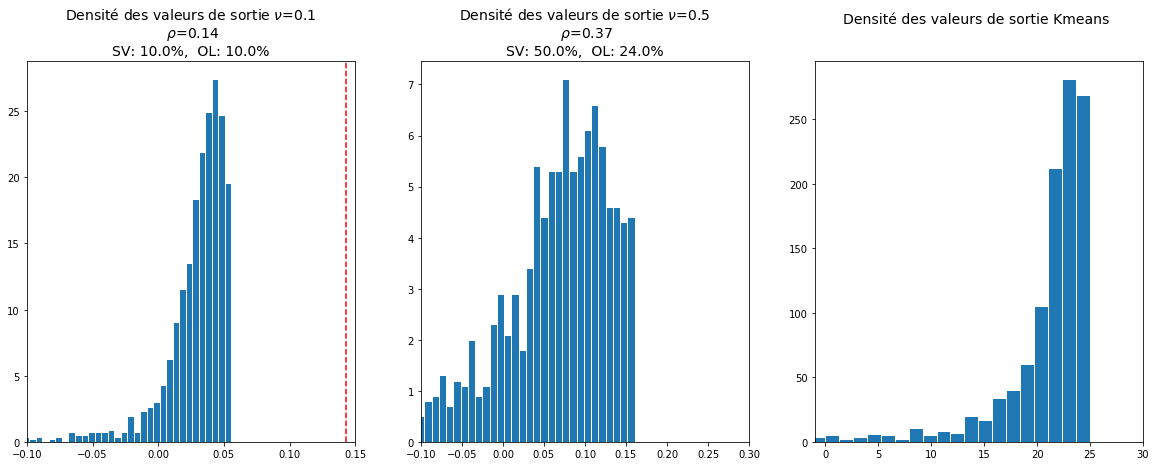

In [114]:
plt.figure(figsize=(20,7))

plt.subplot(131)
plt.hist(y_pred_base,bins=40,fill=True,edgecolor='white',density=True)
plt.title("Densité des valeurs de sortie "+r'$\nu$='+str(0.1) +'\n'+ r' $\rho$='+str(np.round(rho[0],2))+"\n"+\
         "SV: "+str(np.round(len(alpha[alpha>10**(-6)])/len(alpha)*100)) + "%, "+
          " OL: "+str(np.round(len(y_pred[y_pred==-1])/len(y_pred)*100))+"%",size=14)
plt.xlim(-0.1,0.15)

plt.subplot(132)
plt.hist(y_pred_base_2,bins=60,fill=True,edgecolor='white',density=True)
plt.title("Densité des valeurs de sortie "+r'$\nu$='+str(0.5) +'\n'+ r' $\rho$='+str(np.round(rho_2[0],2))+"\n"+\
         "SV: "+str(np.round(len(alpha_2[alpha_2>10**(-6)])/len(alpha_2)*100)) + "%, "+
          " OL: "+str(np.round(len(y_pred_2[y_pred_2==-1])/len(y_pred_2)*100))+"%",size=14)
plt.xlim(-0.1,0.3)

plt.subplot(133)
plt.hist(y_pred_base_km,bins=400,edgecolor='white')
plt.xlim(-1,30)
plt.title("Densité des valeurs de sortie Kmeans \n \n" ,size=14)
plt.savefig('densite_OSVM_KMeans')
plt.show()

### Letter recognition dataset

data source: http://odds.cs.stonybrook.edu/letter-recognition-dataset/

In [83]:
from scipy.io import loadmat
x = loadmat('letter.mat')
X=x['X']
y=x['y'].flatten()
y=y.astype(float)
X=X.astype(int)
y[y==1]=-1
y[y==0]=1
#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

#### OSVM

In [84]:
nu=0.05
sigma2=0.5*256
kernel = ['RBF',sigma2]
alpha, rho = fit(X_train, nu, kernel)
y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()

In [85]:
from sklearn.metrics import confusion_matrix, classification_report
conf=confusion_matrix(y_test,y_pred)
print(conf)
print(classification_report(y_test,y_pred))
print("false positive rate:",np.round(conf[1,0]/np.sum(conf[0][0]+conf[1][0]),2))

[[ 11  15]
 [ 50 404]]
             precision    recall  f1-score   support

       -1.0       0.18      0.42      0.25        26
        1.0       0.96      0.89      0.93       454

avg / total       0.92      0.86      0.89       480

false positive rate: 0.82


In [86]:
nu_list = list(np.arange(0.05,0.15,0.01))+[0.30,0.40,0.50]
nu_list = [np.round(n,2) for n in nu_list]
OL_list, SV_list = OL_SV(nu_list)

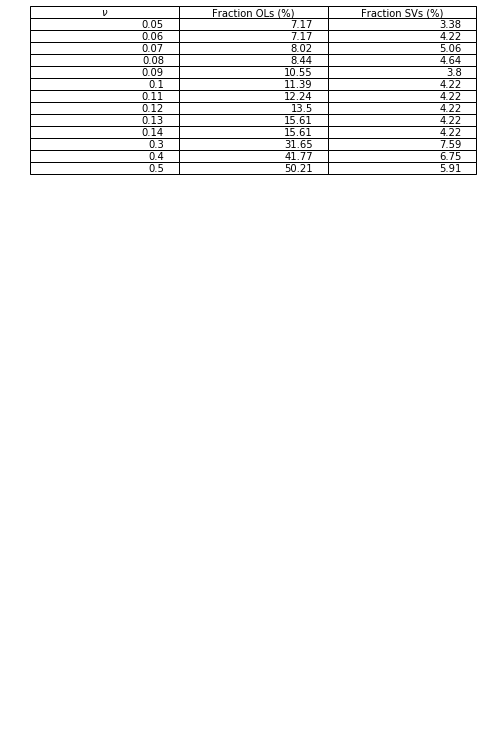

In [87]:
fig = plt.figure(figsize=(8,10))
table = plt.table(cellText=data,colLabels=[r'$\nu$','Fraction OLs (%)','Fraction SVs (%)'],loc='top')
plt.axis('off')
plt.grid('off')

In [43]:
from sklearn.metrics import f1_score

def cross_val(list_sigma2,list_nu,X_train,X_test):
    t=0
    list_score = []
    for nu_val in list_nu:
        for sigma2_val in list_sigma2:
            kernel = ['RBF',sigma2_val]
            alpha, rho = fit(X_train, nu_val, kernel)
            y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()
            #minimize false negatives ?
            list_score.append([nu_val,sigma2_val,f1_score(y_test,y_pred)] )
            t=t+1
        print(100*t/(len(list_nu)*len(list_sigma2)))
    return(list_score)

def best_score(list_score):
    scores = [n[2] for n in list_score]
    index = np.argmax(scores)
    return(list_score[index][0:2])


In [44]:
#cross validation
list_nu=np.arange(0.1,0.8,0.1)
list_sigma2=np.arange(30,100,10)

list_score = cross_val(list_nu,list_sigma2,X_train,X_test)
nu_best, sigma2_best = best_score(list_score)
kernel = ['RBF',sigma2_best]

#final model
alpha, rho = fit(X_train, nu_best, kernel)
y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()

nu_best =0.1
sigma2_best = 90

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

KeyboardInterrupt: 

#### KMEANS

In [245]:
kmeans = OkMeans(X_train)
kmeans.fit(1,k=1)
y_pred = kmeans.predict(X_test)
y_pred = np.sign(y_pred)

In [246]:
from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y_test,y_pred)
print(conf)
print(classification_report(y_test,y_pred))
print("false positive rate:",np.round(conf[1,0]/np.sum(conf[0][0]+conf[1][0]),2))

[[ 31   0]
 [449   0]]
             precision    recall  f1-score   support

       -1.0       0.06      1.00      0.12        31
        1.0       0.00      0.00      0.00       449

avg / total       0.00      0.06      0.01       480

false positive rate: 0.94


/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
